In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
import os

sys.path.append(os.path.abspath('..'))  

from utils.data_training_utils import train_test_model_with_hyperparameter_tuning, train_final_model_for_production


In [2]:
df = pd.read_csv("../data/working_data/data_cleaned_20250827.csv")

In [3]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

In [5]:
from sklearn.preprocessing import LabelEncoder

df_numeric = df.copy()
encoders = {}

for col in df_numeric.select_dtypes(include="category").columns:
    le = LabelEncoder()
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))
    encoders[col] = le

# Save the encoders
with open("../data/app_data/encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [5]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10 , 20],
    "min_samples_leaf": [1, 2, 4, 8]
}

model = RandomForestRegressor(random_state=42)

### Random Forest Model for rental prices 

In [6]:

# Parámetros a explorar (ajustado para ser razonable en tiempo con LOO)
param_grid_2 = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['auto', 'sqrt', 'log2'],
    "bootstrap": [True, False],
    "max_leaf_nodes": [None, 10, 20, 50],
    "ccp_alpha": [0.0, 0.01, 0.1]
}

In [7]:
df_numeric_rent = df_numeric[df_numeric['operation'] == 0]

best_rent_num_model, best_rent_num_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_numeric_rent, drop_features=['operation'])

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best model found: RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=20,
                      n_estimators=50, random_state=42)
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 50}
Best training MAE: 112.99493175718426
Best training R2: 0.958297472617291
·········································
MAE test: 84.41952744834657
R2 test: 0.9683796626015481


In [11]:
final_rent_model, model_path = train_final_model_for_production(best_rent_num_model, df_numeric_rent, drop_features=['operation'], model_dir="../models")

·········································
Final RandomForestRegressor trained with ALL data ✅
MAE (on full data): 71.8947
R2  (on full data): 0.9806
Model saved to: ../models\RandomForestRegressor_rent_production_202509011542.joblib


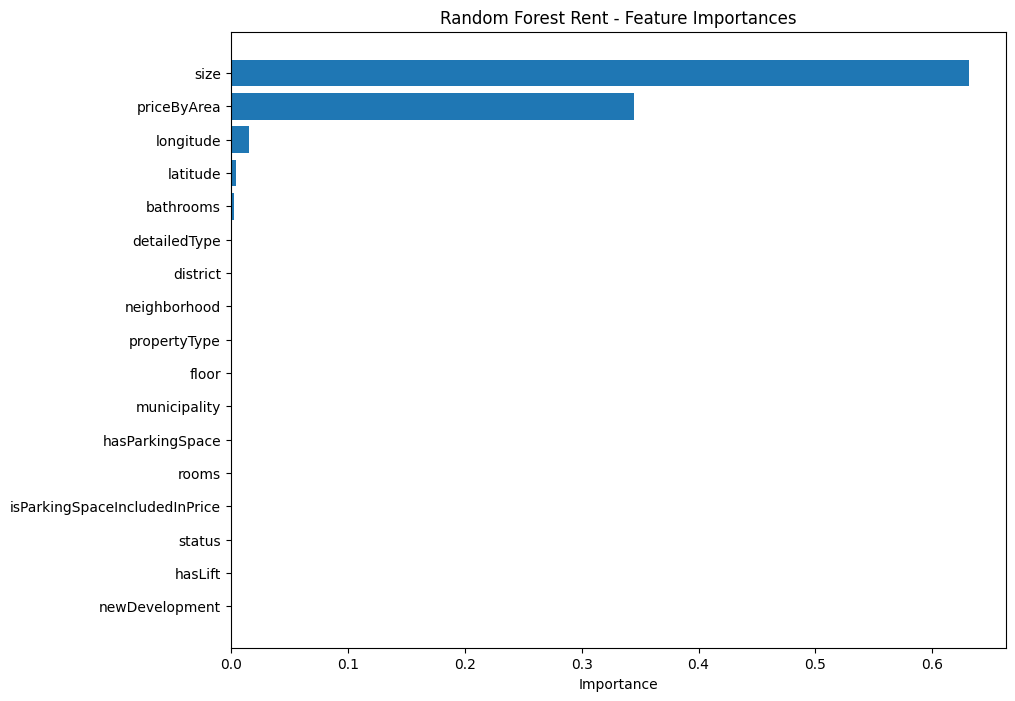

In [13]:
importances = final_rent_model.feature_importances_
indices = np.argsort(importances)[::-1]

X_columns = df_numeric_rent.drop(columns=['price', 'operation']).columns
plt.figure(figsize=(10, 8))
plt.barh(np.array(X_columns)[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Random Forest Rent - Feature Importances")
plt.xlabel("Importance")
plt.show()

### Random Forest Model for sale prices

In [14]:
df_numeric_sale = df_numeric[df_numeric['operation'] == 1]

best_sale_num_model, best_sale_num_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_numeric_sale, drop_features=['operation'])

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best model found: RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=20,
                      n_estimators=50, random_state=42)
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 50}
Best training MAE: 40988.546187541775
Best training R2: 0.9655790414878199
·········································
MAE test: 34420.68317066732
R2 test: 0.9780690889613173


In [15]:
final_sale_model, sale_model_path = train_final_model_for_production(best_sale_num_model, df_numeric_sale, drop_features=['operation'], model_dir="../models")

·········································
Final RandomForestRegressor trained with ALL data ✅
MAE (on full data): 24906.8846
R2  (on full data): 0.9858
Model saved to: ../models\RandomForestRegressor_sale_production_202509011610.joblib


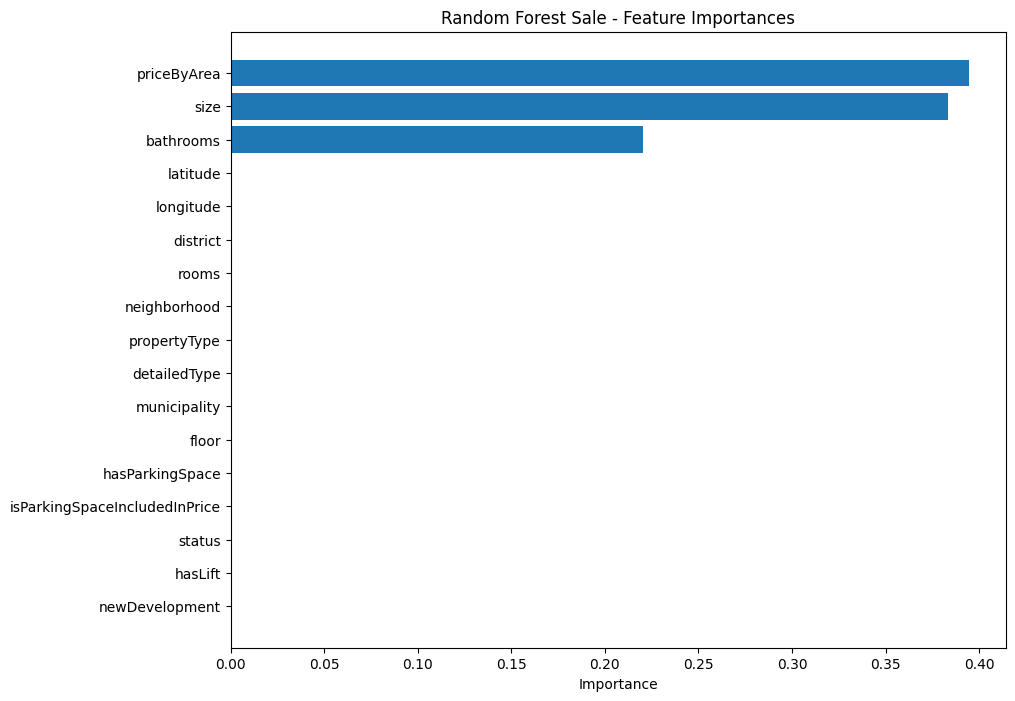

In [16]:
importances = final_sale_model.feature_importances_
indices = np.argsort(importances)[::-1]

X_columns = df_numeric_sale.drop(columns=['price', 'operation']).columns

plt.figure(figsize=(10, 8))
plt.barh(np.array(X_columns)[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Random Forest Sale - Feature Importances")
plt.xlabel("Importance")
plt.show()